# Optimization of a health insurance

\begin{align*}
p_{* \dagger}(x) & \quad = \quad \exp(-7.85785 + 0.01538 x + 0.000577355 x^2)\\
p_{* \diamondsuit_{1}}(x) & \quad = \quad 3\cdot 10^{-4} \cdot (8.4764-1.0985x + 0.055x^2)\\
p_{\diamondsuit_{k} \dagger}(x) & \quad = \quad p_{* \dagger}(x) + 0.008\\
p_{\diamondsuit_{k} *}(x) & \quad = \quad \left \{ \array{ \exp(-0.94(k-1)) \cdot \alpha(x, k), &\text{for } k < 8 \\ 0, & \text{otherwise}} \right.\\
\alpha(x,k) & \quad = \quad \max(0,0.773763-0.01045(x-k + 1))\\
\end{align*}

## Possible strategies

1. No action; then the above model and assumptions are used
2. For all active people one can reduce disability incidence rate (sigma(x)) by 17.5% (RedToInval = 0.175) for an annual cost of 150 (CostActive = 150)
3. For all active people with an age (< 45) one can reduce incidence rate by 70% for an annual cost of 5
4. For disabled people one can increase reactivation probability by 20% for a cost of 1500.

In [1]:
import numpy as np

In [2]:
#Probability stay healty 25-65
def alwayshealty(n):
    if (n < 25): raise ValueError('The age has to be between 25 and 65 years')
    if (n == 25): return 1
    return alwayshealty(n-1) - mua(n - 1) - mui(n - 1)

In [3]:
class Strategy():
        
    def __init__(self):
        # Reduction of the disability incidence rate
        self.sigmareduction = 0.
        # Cost to reduce disability incidence rate
        self.costsigmareduction = 0.
        # Reduce mortality
        self.mureduction = 0.
        # Cost to reduce mortality
        self.costmureduction = 0.
        # Age limit for mortality reduction (<)
        self.mureductionlimitage = 45
        # Reactivation probability increase
        self.reactivationincrease = 0.
        # Reactivation probability increase cost
        self.costreactivationincrease = 0.

    def __hash__(self):
            return hash(self.__class__)
        
    def __eq__(self, other):
             return (self.__class__ == other.__class__)
        
    # Mortality for healthy at age x
    def mua(self, x):
        factor = 1.
        if (x < self.mureductionlimitage): factor = 1 - self.mureduction
        return np.exp(-7.85785 + 0.01538*x + 0.000577355*x**2) * factor

    # Mortality for disabled at age x
    def mui(self, x):
        return(self.mua(x)+0.008)

    #Probability to become disabled at age x
    def sigma(self, x):
        return(3.e-4 * (8.4764-1.0985*x + 0.055*x**2)) * (1 - self.sigmareduction)
    
    def alpha(self, x,k):
        return(max(0,0.773763-0.01045*(x - k + 1)))
    # Reactivation probability for state \diamondsuit_k and age x
    def rx(self, x, k, foreversick):
        if (k>= foreversick): return(0.)
        return np.exp(-0.94*(k-1)) * self.alpha(x, k) * (1 + self.reactivationincrease)

    def stayhealty(self, x):
        return 1 - self.mua(x) - self.sigma(x)

    def staysick(self, x, status, foreversick):
        return 1 - self.mui(x) - self.rx(x, status, foreversick)    
    
    def cost(self):
        return self.costsigmareduction + self.costmureduction + self.costreactivationincrease


        
class NoAction(Strategy):
    
    def __init__(self):
        super().__init__()
        
    def color(self):
        return "b"
    
    def description(self):
        return "No action"


class ReduceDisabilityIncidence(Strategy):
    
    def __init__(self):
        super().__init__()
        # Reduction of the disability incidence rate
        self.sigmareduction = 0.175
        # Cost to reduce disability incidence rate
        self.costsigmareduction = 150
        
    def color(self):
        return "g"
    
    def description(self):
        return "Reduce disability"
    
    
class ReduceMortality(Strategy):
    
    def __init__(self):
        super().__init__()
        # Reduce mortality
        self.mureduction = 0.7
        # Cost to reduce mortality
        self.mureductioncost = 5.

    def color(self):
        return "y"
    
    def description(self):
        return "Reduce mortality"        
        
        
class IncreaseReactivation(Strategy):
    
    def __init__(self):
        super().__init__()
        # Reactivation probability increase
        self.reactivationincrease = 0.2
        # Reactivation probability increase cost
        self.costreactivationincrease = 1500.
        
    def color(self):
        return "r"
    
    def description(self):
        return "Increase reactivation"

In [4]:
# Thiele's equation

class Thiele():
    
    def __init__(self):
        # Caching results
        self.stati = {}
        # Codes for the stati of the insured
        self.healthy = 0
        self.firstsick = 1
        self.foreversick = 8
        self.dead = self.foreversick + 1
        self.sicknessrange = range(1, self.dead)
        self.allrange = range(self.healthy, self.dead + 1)
        # Annual Annuity
        self.annuity = 12000.
        # Interest Rate
        self.interestrate = 0.02
        # Starting Age
        self.x0 = 20
        # End age ie last payment in period [s-1,s[ 
        self.xend = 65
        # Possible strategies
        self.strategies = [NoAction(), ReduceDisabilityIncidence(), ReduceMortality(), IncreaseReactivation()]
        
    
    def alreadycalculated(self, n, status, strat):
        retrieved = self.stati.get(n)
        if (retrieved == None): return False
        else:
            retrieved = retrieved.get(status)
            if (retrieved == None): return False
            else: return (retrieved.get(strat) != None)
    
    def save(self, n, status, strategy, res):
        retrievedyear = self.stati.get(n)
        if (retrievedyear == None): self.stati[n] = {status: {strategy: res}}
        else: 
            retrievedstatus = retrievedyear.get(status)
            if (retrievedstatus == None): retrievedyear[status] = {strategy: res}
            else: self.stati[n][status][strategy] = res
        
    def prepayment(self, n, status, strategy):
        if (status == self.healthy or status == self.dead):
            return strategy.cost()
        elif (status in self.sicknessrange):
            return self.annuity + strategy.cost()
        else:
            raise ValueError('The status given for the prepayment is not contemplated')

    def postpayment(self, n, status, newstatus):
        return 0.

    def transitionprobability(self, n, status, newstatus, strat):
            if (status == self.healthy):
                if (newstatus == self.healthy): return strat.stayhealty(n)
                elif (newstatus == self.firstsick): return strat.sigma(n)
                elif (newstatus == self.dead): return strat.mua(n)
                else: return 0.
            elif (status in self.sicknessrange):
                if (newstatus == self.dead): return strat.mui(n)
                elif (newstatus == self.healthy): return strat.rx(n, status, self.foreversick)
                elif (newstatus == status + 1): return strat.staysick(n, status, self.foreversick)
                else: return 0.
            elif (status == self.dead):
                if (newstatus == self.dead): return 1.
                else: return 0.               
            else:
                raise ValueError(f"The status {status} given for the transition probability is not contemplated")

    def reserves(self, n, status, strat):
        if (n == self.xend): return 0.
        if (status == self.dead): return 0.
        if self.alreadycalculated(n, status, strat): return self.stati[n][status][strat]
        interest = 1/(1 + self.interestrate)
        subsequent = 0
        for newstatus in range(self.dead + 1):
            tp = self.transitionprobability(n, status, newstatus, strat)
            if tp > 0:
                subsequent += tp * (self.postpayment(n, status, newstatus) + self.minreserves(n+1, newstatus))
        res = self.prepayment(n, status, strat) + interest * subsequent
        self.save(n, status, strat, res)
        return res
    
    def minreserves(self, n, status):
        return min([self.reserves(n, status, strat) for strat in self.strategies])

In [5]:
c = Thiele()
c.reserves(c.x0, 0, NoAction())
ages = [i for i in range(c.x0, c.xend + 1)]
rsvs = [c.reserves(j, 0, NoAction()) for j in ages]

In [6]:
import matplotlib.pyplot as plt

plt.plot(ages, rsvs, linewidth=0.6, marker = ".")
plt.title("Reserves at different ages of the insured")
plt.xlabel("Age of the insured")
plt.ylabel("Reserves")
plt.grid(color = 'green', linestyle = '--', linewidth = 0.5)
plt.xticks(np.arange(min(ages), max(ages)+1, 5))
plt.show()

<Figure size 640x480 with 1 Axes>

In [7]:
base = [[min(c.strategies, key = lambda strat: c.reserves(j, s, strat)) for j in ages] for s in c.allrange]

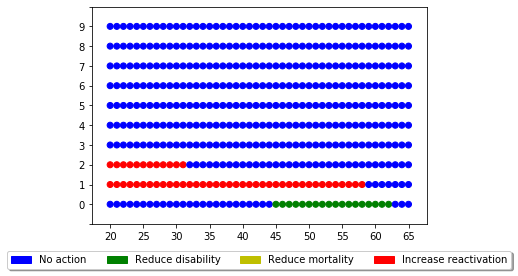

In [8]:
import matplotlib.patches as mpatches

fig, ax = plt.subplots()
for s in c.allrange:
    ax.scatter(ages, [s for t in base[s]], color=[t.color() for t in base[s]])

plt.yticks(range(c.healthy - 1, c.dead + 2))
plt.xticks(np.arange(min(ages), max(ages)+1, 5))
handles = [mpatches.Patch(color=st.color(), label=st.description()) for st in c.strategies]
ax.legend(handles = handles, loc='upper center', bbox_to_anchor=(0.5, -0.1),
          fancybox=True, shadow=True, ncol=5)
plt.setp(ax.get_yticklabels()[0], visible=False)
plt.setp(ax.get_yticklabels()[-1], visible=False)

plt.show()